<a href="https://colab.research.google.com/github/goodu001/lazada_astaxanthin_machine_learning/blob/main/lazada_astaxanthin_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1 — Imports (with auto-install for Drive API / gspread if needed)
import sys, subprocess

def _pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

try:
    from googleapiclient.discovery import build  # Drive API
except Exception:
    _pip_install(["google-api-python-client"])
    from googleapiclient.discovery import build

try:
    import gspread
except Exception:
    _pip_install(["gspread"])
    import gspread

import pandas as pd
import numpy as np
import re
from pathlib import Path

# ML
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

print("Imports ready.")


Imports ready.


In [3]:
# Cell 2 — Mount Drive & load data (.gsheet resolver supported)

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()

service = build('drive', 'v3', cache_discovery=False)
gc = gspread.authorize(creds)

# === Change your path here as needed ===
DATA_PATH = Path('/content/drive/MyDrive/lazada_astaxanthin_allpages.gsheet')
print('Using file:', DATA_PATH)

def load_from_gsheet_shortcut(shortcut_path: Path) -> pd.DataFrame:
    """Resolve a .gsheet shortcut in Drive to its target Spreadsheet and load as DataFrame."""
    # Search by name with and without .gsheet suffix
    name_candidates = [shortcut_path.name, shortcut_path.stem]
    q_names = " or ".join([f"name = '{n}'" for n in name_candidates])
    query = f"({q_names}) and trashed = false"

    resp = service.files().list(
        q=query,
        fields="files(id, name, mimeType)",
        supportsAllDrives=True,
        includeItemsFromAllDrives=True
    ).execute()

    files = resp.get('files', [])
    if not files:
        raise RuntimeError(f"Cannot find file in Drive by names: {name_candidates}")

    f = files[0]
    mime = f['mimeType']

    # Resolve shortcut to target
    if mime == 'application/vnd.google-apps.shortcut':
        meta = service.files().get(
            fileId=f['id'],
            fields="id, name, shortcutDetails",
            supportsAllDrives=True
        ).execute()
        sc = meta.get('shortcutDetails', {})
        target_id = sc.get('targetId')
        target_mime = sc.get('targetMimeType')
    else:
        target_id = f['id']
        target_mime = mime

    # If target is a Google Sheet -> use gspread
    if target_mime == 'application/vnd.google-apps.spreadsheet':
        sh = gc.open_by_key(target_id)
        ws = sh.get_worksheet(0)  # first worksheet
        rows = ws.get_all_records()
        df = pd.DataFrame(rows)
        print(f"Loaded via gspread: worksheet='{ws.title}', rows={len(rows)}")
        return df

    # Fallback: try CSV export if supported
    try:
        csv_url = f"https://docs.google.com/uc?export=download&id={target_id}"
        df = pd.read_csv(csv_url)
        print("Loaded via CSV export URL.")
        return df
    except Exception as e:
        raise RuntimeError(f"Unsupported target mimeType or permissions issue: {target_mime}. Error: {e}")

# Decide how to read based on suffix
if DATA_PATH.suffix.lower() == '.gsheet':
    df = load_from_gsheet_shortcut(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

print('Shape:', df.shape)
print('Columns:', list(df.columns))
display(df.head(10))


Mounted at /content/drive
Using file: /content/drive/MyDrive/lazada_astaxanthin_allpages.gsheet
Loaded via gspread: worksheet='lazada_astaxanthin_allpages', rows=1407
Shape: (1407, 9)
Columns: ['product_id', 'name', 'price_text', 'price', 'sold_text', 'sold_est', 'rating_text', 'reviews_text', 'product_url']


,product_id,name,price_text,price,sold_text,sold_est,rating_text,reviews_text,product_url
0,438,Omilay Astaxanthin Gummy อุดมไปด้วย วิตามินซี ...,฿189.00,189.00,(0)กรุงเทพมหานคร,0,,,https://www.lazada.co.th/products/pdp-i5749156...
1,750,[พร้อมส่ง + แท้100% + เก็บเงินปลายทางได้] Vist...,฿419.00,419.00,(0)นครราชสีมา,0,,,https://www.lazada.co.th/products/pdp-i2078620...
2,949,Red Diamond Astaxanthin 1 กระปุก แอสต้าแซนริน ...,฿399.00,399.00,(0)ขอนแก่น,0,,,https://www.lazada.co.th/products/pdp-i5519199...
3,1313,BioActive+Conentrated Liquid Asta Drink Astaxa...,"฿1,990.00",1990.00,(0)เชียงราย,0,,,https://www.lazada.co.th/products/pdp-i5840798...
4,26,แอสตาแซนธิน - ดูดซึมได้สูง - การเผาผลาญและสุขภ...,฿165.45,165.45,(1)สมุทรปราการ,1,,,https://www.lazada.co.th/products/pdp-i5747083...
5,54,30/60/120 แคปซูล แอสตาแซนธิน + ไลโคปีน - เพิ่ม...,฿83.50,83.50,(1)สมุทรปราการ,1,,,https://www.lazada.co.th/products/pdp-i5829973...
6,123,แอสทาแคริน - บำรุงสุขภาพหัวใจและหลอดเลือด - ระ...,฿162.00,162.00,(1)สมุทรปราการ,1,,,https://www.lazada.co.th/products/pdp-i5796019...
7,139,อาหารเสริมแอสตาแซนธิน Tecepec ประกอบด้วยแอสตาแ...,฿140.27,140.27,(1)ลำพูน,1,,,https://www.lazada.co.th/products/pdp-i5816636...
8,146,Tecepec Astaxanthin 4 มก. ส่งเสริมการฟื้นฟูการ...,฿155.00,155.00,(1)สมุทรปราการ,1,,,https://www.lazada.co.th/products/pdp-i5617913...
9,151,COOLKIN Astaxanthin Elite 120 เม็ด | ช่วยเพิ่ม...,฿45.00,45.00,(1)เชียงใหม่,1,,,https://www.lazada.co.th/products/pdp-i5852433...


In [4]:
# Cell 3 — Cleaning & parsing helpers

def _to_float(text):
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return np.nan
    s = str(text).strip()
    if s == '' or s.lower() in {'nan','none','null','-'}:
        return np.nan
    s = s.replace('฿','').replace(',','')
    s = re.sub(r'\s+', ' ', s)
    s = s.replace('–','-').replace('—','-')
    if '-' in s and any(ch.isdigit() for ch in s):
        parts = [p for p in s.split('-') if any(ch.isdigit() for ch in p)]
        nums = []
        for p in parts:
            m = re.search(r'(\d+(\.\d+)?)', p)
            if m:
                nums.append(float(m.group(1)))
        if nums:
            return float(np.mean(nums))
    m = re.search(r'(\d+(\.\d+)?)', s)
    return float(m.group(1)) if m else np.nan

def parse_price(x):
    try:
        return _to_float(x)
    except Exception:
        return np.nan

def parse_number_with_suffix(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    s = str(x).strip().lower().replace('+','')
    if s == '' or s in {'nan','none','null','-'}:
        return np.nan
    try:
        return float(s)
    except ValueError:
        pass
    m = re.match(r'^\s*(\d+(\.\d+)?)([kKmM])\s*$', s)
    if m:
        val = float(m.group(1)); suf = m.group(3).lower()
        return val * (1_000 if suf=='k' else 1_000_000)
    m = re.search(r'(\d{1,3}(?:,\d{3})+|\d+(\.\d+)?)', s)
    return float(m.group(0).replace(',','')) if m else np.nan

def pick_col(df, candidates):
    for c in candidates:
        for col in df.columns:
            if col.lower().strip() == c:
                return col
    return None

print("Helpers ready.")


Helpers ready.


In [5]:
# Cell 4 — Build cleaned dataset with name, price, sold_est

name_col = pick_col(df, ['name','product_name','title'])
price_col = pick_col(df, ['price','price_thb','price_text'])
sold_col  = pick_col(df, ['sold_est','sold_vol','sold','sold_estimated','sold_count','sold_qty'])

print('Detected -> name:', name_col, '| price:', price_col, '| sold:', sold_col)

df_work = df.copy()

# numeric price
if price_col:
    if price_col == 'price' and pd.api.types.is_numeric_dtype(df_work[price_col]):
        df_work['price_num'] = df_work[price_col].astype(float)
    else:
        df_work['price_num'] = df_work[price_col].apply(parse_price)
else:
    df_work['price_num'] = np.nan

# numeric sold
if sold_col:
    df_work['sold_num'] = df_work[sold_col].apply(parse_number_with_suffix)
else:
    df_work['sold_num'] = np.nan

cleaned = pd.DataFrame({
    'name': df_work[name_col] if name_col else df_work.index.astype(str),
    'price': df_work['price_num'],
    'sold_est': df_work['sold_num'],
})

before = cleaned.shape[0]
cleaned = cleaned.dropna(subset=['price','sold_est'])
cleaned = cleaned[(cleaned['price'] > 0) & (cleaned['sold_est'] >= 0)].drop_duplicates().reset_index(drop=True)
after = cleaned.shape[0]

print(f'Rows before cleaning: {before}  |  after: {after}')
display(cleaned.head(10))
display(cleaned.describe())


Detected -> name: name | price: price | sold: sold_est
Rows before cleaning: 1407  |  after: 1391


,name,price,sold_est
0,Omilay Astaxanthin Gummy อุดมไปด้วย วิตามินซี ...,189.00,0.0
1,[พร้อมส่ง + แท้100% + เก็บเงินปลายทางได้] Vist...,419.00,0.0
2,Red Diamond Astaxanthin 1 กระปุก แอสต้าแซนริน ...,399.00,0.0
3,BioActive+Conentrated Liquid Asta Drink Astaxa...,1990.00,0.0
4,แอสตาแซนธิน - ดูดซึมได้สูง - การเผาผลาญและสุขภ...,165.45,1.0
5,30/60/120 แคปซูล แอสตาแซนธิน + ไลโคปีน - เพิ่ม...,83.50,1.0
6,แอสทาแคริน - บำรุงสุขภาพหัวใจและหลอดเลือด - ระ...,162.00,1.0
7,อาหารเสริมแอสตาแซนธิน Tecepec ประกอบด้วยแอสตาแ...,140.27,1.0
8,Tecepec Astaxanthin 4 มก. ส่งเสริมการฟื้นฟูการ...,155.00,1.0
9,COOLKIN Astaxanthin Elite 120 เม็ด | ช่วยเพิ่ม...,45.00,1.0


,price,sold_est
count,1391.000000,1391.000000
mean,704.760086,719.987060
std,699.650403,6393.332265
min,11.000000,0.000000
25%,229.000000,0.000000
50%,448.000000,3.000000
75%,965.000000,54.000000
max,5900.000000,100400.000000


In [6]:
# Cell 5 — Feature engineering (log transforms + light text parsing)

def extract_mg(text):
    if not isinstance(text, str): return np.nan
    m = re.search(r'(\d+)\s*mg', text.lower())
    return float(m.group(1)) if m else np.nan

def extract_pack(text):
    if not isinstance(text, str): return np.nan
    m = re.search(r'(\d+)\s*(caps|capsules|เม็ด|แคปซูล|ซอง|เม็ด/กล่อง|เม็ด/ขวด)', text.lower())
    return float(m.group(1)) if m else np.nan

df_ml = cleaned.copy()
df_ml['price_log'] = np.log1p(df_ml['price'])
df_ml['sold_log']  = np.log1p(df_ml['sold_est'])
df_ml['mg']        = df_ml['name'].apply(extract_mg)
df_ml['pack']      = df_ml['name'].apply(extract_pack)

num_feats = ['price_log','sold_log','mg','pack']
X_num = df_ml[num_feats].fillna(0.0).values

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_num)

print('Feature matrix shape:', X_scaled.shape, '| features =', num_feats)
display(df_ml.head(5))


Feature matrix shape: (1391, 4) | features = ['price_log', 'sold_log', 'mg', 'pack']


,name,price,sold_est,price_log,sold_log,mg,pack
0,Omilay Astaxanthin Gummy อุดมไปด้วย วิตามินซี ...,189.00,0.0,5.247024,0.000000,6.0,60.0
1,[พร้อมส่ง + แท้100% + เก็บเงินปลายทางได้] Vist...,419.00,0.0,6.040255,0.000000,4.0,30.0
2,Red Diamond Astaxanthin 1 กระปุก แอสต้าแซนริน ...,399.00,0.0,5.991465,0.000000,NaN,NaN
3,BioActive+Conentrated Liquid Asta Drink Astaxa...,1990.00,0.0,7.596392,0.000000,NaN,NaN
4,แอสตาแซนธิน - ดูดซึมได้สูง - การเผาผลาญและสุขภ...,165.45,1.0,5.114695,0.693147,NaN,NaN


In [7]:
# Cell 6 — K selection via silhouette score
best_k, best_score, best_model = None, -1, None
scores = {}

for k in range(3, 9):  # try k = 3..8
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    if len(set(labels)) < 2:
        continue
    score = silhouette_score(X_scaled, labels)
    scores[k] = score
    if score > best_score:
        best_k, best_score, best_model = k, score, km

print("Silhouette scores by k:", {k: round(v, 4) for k, v in scores.items()})
print(f"Chosen k={best_k} with silhouette={best_score:.4f}")


Silhouette scores by k: {3: np.float64(0.9872), 4: np.float64(0.9759), 5: np.float64(0.9707), 6: np.float64(0.971), 7: np.float64(0.9706), 8: np.float64(0.3037)}
Chosen k=3 with silhouette=0.9872


In [8]:
# Cell 7 — Fit best model & attach labels
df_ml['cluster_km'] = best_model.predict(X_scaled)

# Quick profiling
prof = (df_ml
        .groupby('cluster_km')
        .agg(products=('name','count'),
             price_median=('price','median'),
             sold_median=('sold_est','median'),
             price_p75=('price', lambda x: x.quantile(0.75)),
             sold_p75=('sold_est', lambda x: x.quantile(0.75)))
        .sort_values('price_median')
       )

print("Cluster profile:")
display(prof)
display(df_ml[['name','price','sold_est','cluster_km']].head(10))


Cluster profile:


,products,price_median,sold_median,price_p75,sold_p75
cluster_km,,,,,
2,2,149.0,753.5,164.00,1126.75
0,1386,448.0,3.0,964.69,53.75
1,3,1990.0,0.0,2324.50,79.00


,name,price,sold_est,cluster_km
0,Omilay Astaxanthin Gummy อุดมไปด้วย วิตามินซี ...,189.00,0.0,0
1,[พร้อมส่ง + แท้100% + เก็บเงินปลายทางได้] Vist...,419.00,0.0,0
2,Red Diamond Astaxanthin 1 กระปุก แอสต้าแซนริน ...,399.00,0.0,0
3,BioActive+Conentrated Liquid Asta Drink Astaxa...,1990.00,0.0,0
4,แอสตาแซนธิน - ดูดซึมได้สูง - การเผาผลาญและสุขภ...,165.45,1.0,0
5,30/60/120 แคปซูล แอสตาแซนธิน + ไลโคปีน - เพิ่ม...,83.50,1.0,0
6,แอสทาแคริน - บำรุงสุขภาพหัวใจและหลอดเลือด - ระ...,162.00,1.0,0
7,อาหารเสริมแอสตาแซนธิน Tecepec ประกอบด้วยแอสตาแ...,140.27,1.0,0
8,Tecepec Astaxanthin 4 มก. ส่งเสริมการฟื้นฟูการ...,155.00,1.0,0
9,COOLKIN Astaxanthin Elite 120 เม็ด | ช่วยเพิ่ม...,45.00,1.0,0


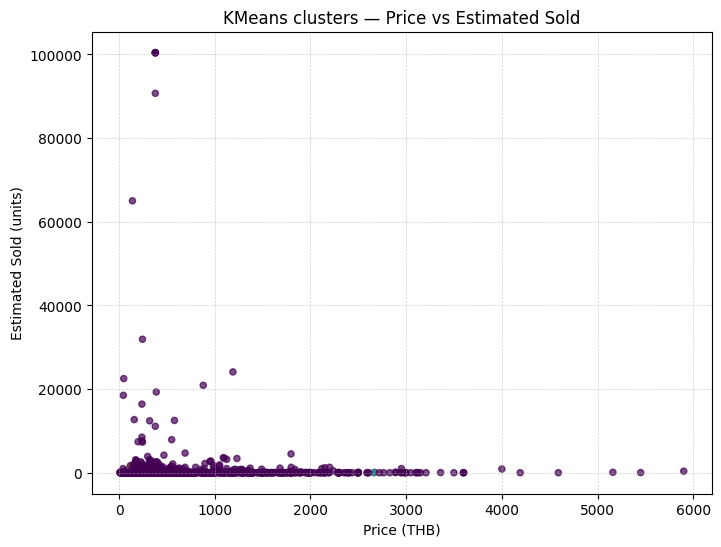

In [9]:
# Cell 8 — Scatter: price vs sold_est (colored by cluster)
if not df_ml.empty:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_ml['price'], df_ml['sold_est'], c=df_ml['cluster_km'], alpha=0.7, s=20)
    plt.xlabel('Price (THB)')
    plt.ylabel('Estimated Sold (units)')
    plt.title('KMeans clusters — Price vs Estimated Sold')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.show()
else:
    print("No data to plot.")


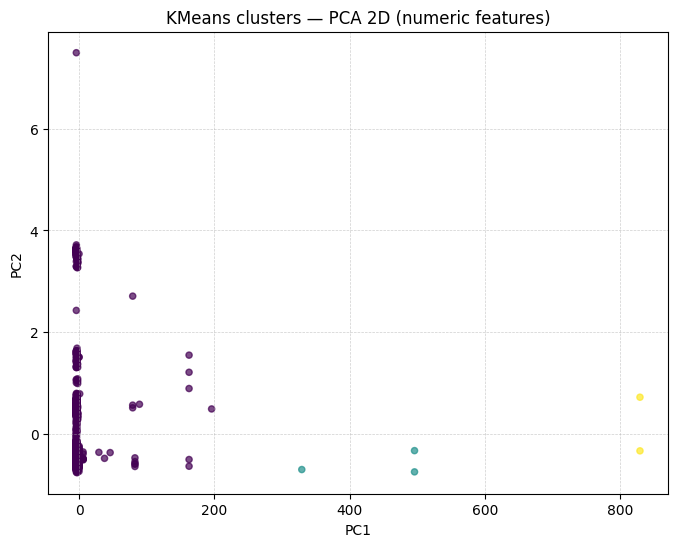

In [10]:
# Cell 9 — PCA 2D visualization of numeric feature space
if X_scaled.shape[0] > 1:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8, 6))
    plt.scatter(X2[:,0], X2[:,1], c=df_ml['cluster_km'], alpha=0.7, s=20)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('KMeans clusters — PCA 2D (numeric features)')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.show()
else:
    print("Not enough rows for PCA.")


In [11]:
# Cell 10 — Save segmented table to Drive
out_dir = Path('/content/drive/MyDrive')
out_csv = out_dir / 'lazada_astaxanthin_segments.csv'
df_ml[['name','price','sold_est','cluster_km']].to_csv(out_csv, index=False, encoding='utf-8-sig')
print('Saved segments CSV ->', out_csv)


Saved segments CSV -> /content/drive/MyDrive/lazada_astaxanthin_segments.csv
